In [3]:
import os
from pathlib import Path
import polars as pl
import re
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.topic_extractor as topic_extractor
import infineac.process_text as process_text

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
random.seed(111)

c:\Users\fgabelbe\AppData\Local\miniconda3\envs\infineac\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\fgabelbe\AppData\Local\miniconda3\envs\infineac\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\fgabelbe\AppData\Local\miniconda3\envs\

## Load NLP model

In [1]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")
nlp_stanza.add_pipe('sentencizer')

c:\Users\fgabelbe\AppData\Local\miniconda3\envs\infineac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-18 20:58:05 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-09-18 20:58:07 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-09-18 20:58:07 WARNING: GPU requested, but is not available!
2023-09-18 20:58:07 INFO: Using device: cpu
2023-09-18 20:58:07 INFO: Loading: tokenize
2023-09-18 20:58:07 INFO: Loading: lemma
2023-09-18 20:58:08 INFO: Done loading processors!


## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [5]:
# files = [Path("../data/transcripts/2022/15203138_T.xml")]
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files)

Files: 100%|██████████| 189501/189501 [1:58:12<00:00, 26.72it/s]  


Check if all positions are valid

In [6]:
process_event.test_positions(events)

## Filter data

Filter out all events that are not in the given time range and do not include the given keywords.

In [12]:
events_filt_all = process_event.filter_events(events, year = 2019, keywords = {"russia":1, "ukraine":1}, modifier_words=[])
events_filt = process_event.filter_events(events, year = 2019, keywords = {"russia":1, "ukraine":1})
len(events_filt)

Filtering events


Events: 100%|██████████| 189501/189501 [01:12<00:00, 2611.10it/s]


Filtering events


Events: 100%|██████████| 189501/189501 [17:14<00:00, 183.23it/s] 


19909

In [11]:
helper.save_data(events, "data/events", compression="lz4")

In [13]:
helper.save_data(events_filt, "data/events_filt", compression="lz4")

List all events, that are filtered out due to modifier words preceding the keywords.

In [14]:
events_filtered_filter_words = []
ids_filtered_events = []
for i, event in enumerate(events_filt):
    ids_filtered_events.append(event['id'])
for event in events_filt_all:
    if event['id'] not in ids_filtered_events:
        events_filtered_filter_words.append(event)
print(len(events_filtered_filter_words))
process_event.extract_passages_from_events(events_filtered_filter_words, keywords=["russia", "ukraine"], modifier_words=[], nlp_model=nlp_stanza)

16
Extracting passages from events


Events: 100%|██████████| 16/16 [00:01<00:00, 13.69it/s]


[[[[['However, in June, year-over-year volume growth in all countries, except Russia, driven by strong demand recovery and share gains in key countries, resulted in year-over-year net sales growth and positive EBIT in the month.']]],
  []],
 [[[['As for automotive glass, in addition to depreciation of euro, demand declines in areas except Russia.']]],
  []],
 [[[['Napo EU, which will be a private company, will have an exclusive license to crofelemer, our novel, proprietary drug for the indications of inflammatory diarrhea and the current approved indication of crofelemer, Mytesi in the United States HIV-related diarrhea, and this is the exclusive license in Europe, excluding Russia.']]],
  []],
 [[[['Napo EU is currently a wholly-owned European subsidiary of Napo Pharmaceuticals, Inc. in Italy with an exclusive European, excluding Russia, license to crofelemer technology from Jaguar.'],
    ["Napo Pharma's wholly-owned subsidiary, Napo EU, has executed a license agreement with Jaguar g

## Exploration

In [49]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company = [event['company_name'] for event in events_filt]
ticker = [event['company_ticker'] if "company_ticker"!="\n" else "NA" for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
numeric_values = mdates.date2num(dates)

russia_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

In [77]:
ticker = [event['company_ticker'] if event["company_ticker"]!="\n  " else "NA" for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in ticker]

Create a DataFrame with the following columns:

In [93]:
df = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company': company,
                   'ticker':ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'dates_num' : numeric_values,
                   'russia': russia_and_sanction,
                   'russia_count': russia_count,
                   'sanction_count': sanction_count,
                   'election': election})

Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

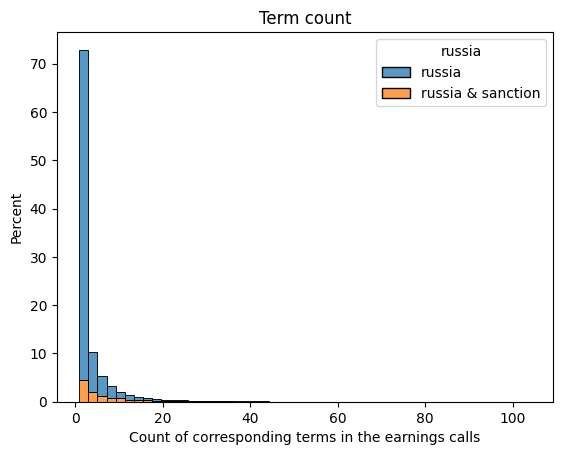

In [17]:
sns.histplot(df[df['russia_count']>=1], x='russia_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [18]:
np.array(russia_count).mean()

2.8327389622783667

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [19]:
np.array([el for el in russia_count if el > 0]).mean()

3.6488742236024843

Average mentions of "sanction" per earnings call.

In [20]:
np.array([el for el in sanction_count if el > 0]).mean()

2.442906574394464

Event distribution over time highlighting the different categories.

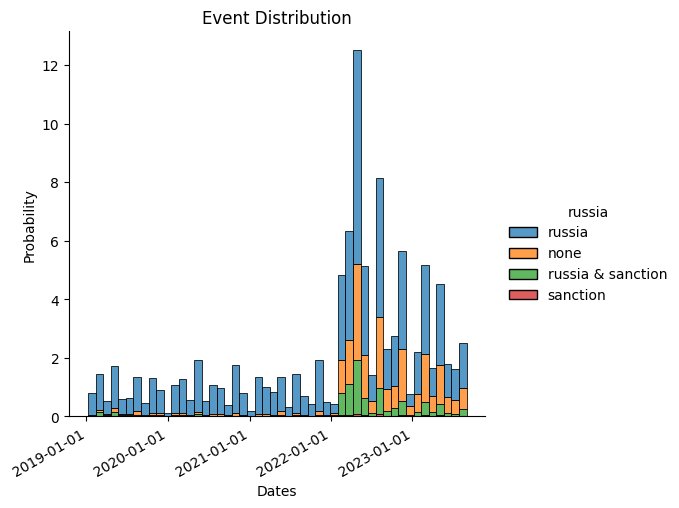

In [21]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

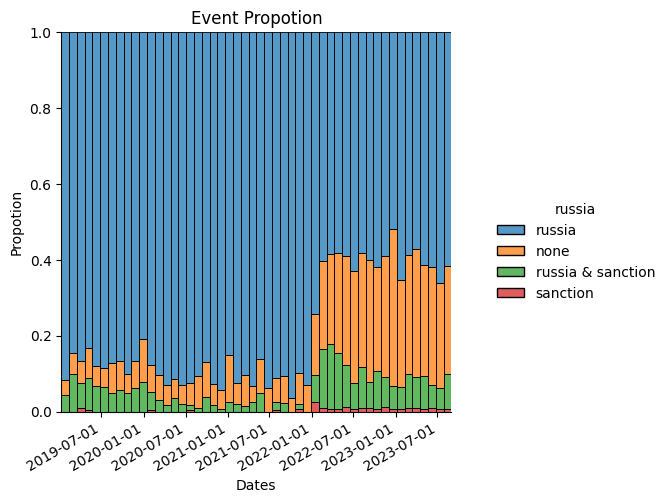

In [22]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Propotion')
plt.title('Event Propotion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

## Preprocess and extract corpus

In [67]:
events_filt = helper.load_data("data/events_filt.lz4")

Create different types of corpora:
1. Corpus with a window of 1 sentence and not joining adjacent sentences.
2. Corpus with a window of 1 sentence and joining adjacent sentences.
3. Corpus with a window of 3 sentences and joining adjacent sentences.
4. Corpus with a window of 5 sentences and joining adjacent sentences.
5. Corpus with a window that includes the whole paragraph from the keywords on.

In [23]:
corpus_window_0_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=False,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_0_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [40:57<00:00,  8.10it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 70658/70658 [22:04<00:00, 53.34it/s] 


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes""",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,1,"""And it goes to…","""go germany cru…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,2,"""The Russian au…","""authority talk…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,3,"""So it is -- in…","""germany access…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""


In [26]:
corpus_window_0_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_0_join_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [40:07<00:00,  8.27it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 62081/62081 [20:49<00:00, 49.70it/s]  


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes""",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,1,"""And it goes to…","""go germany cru…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,2,"""The Russian au…","""authority talk…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,3,"""So it is -- in…","""germany access…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""


In [27]:
corpus_window_3_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,2],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_3_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [40:06<00:00,  8.27it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 58090/58090 [25:39<00:00, 37.73it/s]  


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes pipe druzh…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,1,0,"""And I had the …","""opportunity mi…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
1,0,0,0,0,"""This year, we …","""part book line…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""
1,1,0,0,0,"""And the sum of…","""sum income exp…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""


In [28]:
corpus_window_5_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,4],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_5_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [40:00<00:00,  8.29it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 57086/57086 [26:53<00:00, 35.38it/s]  


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes pipe druzh…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,1,0,"""And I had the …","""opportunity mi…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
1,0,0,0,0,"""This year, we …","""part book line…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""
1,1,0,0,0,"""We entered int…","""enter sale agr…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""


In [29]:
corpus_window_whole_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,-1],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_whole_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [39:56<00:00,  8.31it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 57114/57114 [32:07<00:00, 29.63it/s]  


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes pipe druzh…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,1,0,"""And I had the …","""opportunity mi…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
1,0,0,0,0,"""This year, we …","""part book line…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""
1,1,0,0,0,"""We entered int…","""enter sale agr…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""


Save and load data

In [31]:
helper.save_data(corpus_window_0_df, "data/corpus_window_0_df_no_answer", compression="lz4")
helper.save_data(corpus_window_0_join_df, "data/corpus_window_0_join_df_no_answer", compression="lz4")
helper.save_data(corpus_window_3_df, "data/corpus_window_3_join_df_no_answer", compression="lz4")
helper.save_data(corpus_window_5_df, "data/corpus_window_5_join_df_no_answer", compression="lz4")
helper.save_data(corpus_window_whole_df, "data/corpus_window_whole_join_df_no_answer", compression="lz4")

In [7]:
corpus_window_0_df = helper.load_data("data/corpus_window_0_df_no_answer.lz4")
corpus_window_0_join_df = helper.load_data("data/corpus_window_0_join_df_no_answer.lz4")
corpus_window_3_df = helper.load_data("data/corpus_window_3_join_df_no_answer.lz4")
corpus_window_5_df = helper.load_data("data/corpus_window_5_join_df_no_answer.lz4")
corpus_window_whole_df = helper.load_data("data/corpus_window_whole_join_df_no_answer.lz4")

## Extract Strategies

In [9]:
corpus_window_0_df = process_text.get_strategies(dataframe=corpus_window_0_df)
corpus_window_0_join_df = process_text.get_strategies(dataframe=corpus_window_0_join_df)
corpus_window_3_df = process_text.get_strategies(dataframe=corpus_window_3_df)
corpus_window_5_df = process_text.get_strategies(dataframe=corpus_window_5_df)
corpus_window_whole_df = process_text.get_strategies(dataframe=corpus_window_whole_df)

Strategies: 100%|██████████| 3/3 [00:54<00:00, 18.20s/it]


In [10]:
sum(corpus_window_0_df['exit_strategy'])

4694

### Analyse corpus

In [11]:
lengths = [len(doc) for doc in corpus_window_0_df['processed_text'].to_list()]
np.argmax(np.array(lengths))

63972

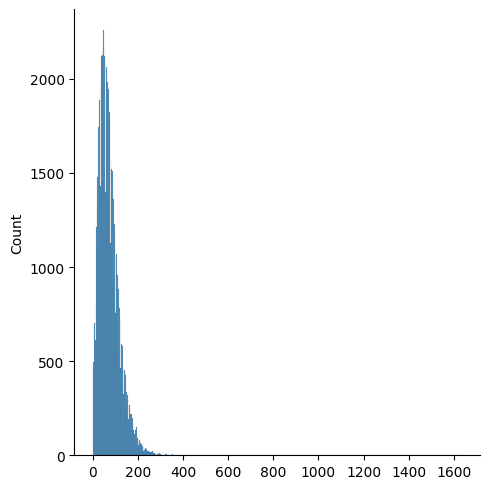

In [12]:
sns.displot(np.array(lengths))

## Extract topics

In [13]:
from bertopic.representation import KeyBERTInspired
# from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
from transformers import pipeline
# from bertopic.representation import TextGeneration
# from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

# vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=10)


# main_representation = KeyBERTInspired()
inspired_model = KeyBERTInspired()

# sentence model
# sentence_model = SentenceTransformer("all-mpnet-base-v2")
sentence_model_light = SentenceTransformer("all-MiniLM-L6-v2")

# mmr model
mmr_model = MaximalMarginalRelevance(diversity=0.4)

# pos model
# nlp_stanza_pos = spacy_stanza.load_pipeline("en", processors="tokenize, pos")
# pos_model = PartOfSpeech(nlp_stanza_pos)

# Create a generator model
# prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"
# generator = pipeline('text2text-generation', model='google/flan-t5-base')
# generator_model = TextGeneration(generator)

# chain models
chain_model_1 = [inspired_model, mmr_model]
# chain_model_2 = [inspired_model, mmr_model, pos_model]
# chain_model_3 = [inspired_model, pos_model, mmr_model]
# generator_chain_model_1 = [inspired_model, mmr_model, generator_model]
# generator_chain_model_2 = [inspired_model, mmr_model, pos_model, generator_model]


# Add all models together to be run in a single `fit`
representation_model = {
   "Main": inspired_model,
   # "Pos":  pos_model,
   "Chain: Inspired - MMR":  chain_model_1,
   # "Chain: Inspired - MMR - POS":  chain_model_2,
   # "Chain: Inspired - POS - MMR":  chain_model_3,
   # "Generator": generator_model,
   # "Generator chain: Inspired - MMR": generator_chain_model_1,
   # "Generator chain: Inspired - MMR - POS": generator_chain_model_2
}

### 1 - Only sentence
* Sentence window: 0
* No join

In [14]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_0_df['processed_text'].to_list())
topic_model_0, topics_0, probs_0 = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 2155/2155 [2:05:12<00:00,  3.49s/it]  
2023-09-18 23:16:19,802 - BERTopic - Transformed documents to Embeddings
2023-09-18 23:19:44,928 - BERTopic - Reduced dimensionality
2023-09-19 00:58:14,420 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [15]:
topics_0_filled = helper.fill_list_from_mapping(topics_0, bridge, -2)
groups_0 = topic_extractor.categorize_topics(topic_model_0.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_0 = groups_0.hstack(pl.DataFrame(topic_model_0.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_0_filled, groups_0)
groups_0.filter(pl.col("n")!=-1).groupby(("category")).agg(pl.col("Count").sum()).sort("Count", descending=True)

category,Count
str,i64
"""commodity""",6525
"""finance""",5638
"""macro demand""",5365
"""indirect geogr…",4925
"""other""",2687
"""macro inflatio…",2028
"""energy""",1516
"""supply chain""",1363
"""compliance""",1309


In [16]:
# corpus_window_0_df = corpus_window_0_df.drop(columns=['topic', "year", "category", "keywords", "Count", "Name", "Representative_Docs"])
corpus_window_0_df = corpus_window_0_df.with_columns(pl.Series('year', corpus_window_0_df['date'].dt.year()))
corpus_window_0_df = corpus_window_0_df.hstack(topics_df)
helper.save_data(corpus_window_0_df, "data/corpus_window_0_df_topics", compression="lz4")

In [17]:
corpus_window_0_df_agg = topic_extractor.get_topics_per_company(corpus_window_0_df)
corpus_window_0_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_0.xlsx")

#### Hierarchical clustering

In [ ]:
hierarchical_topics = topic_model_0.hierarchical_topics(corpus_window_0_df['processed_text'].to_list())
topics_grouped = topic_extractor.get_groups_from_hierarchy(hierarchical_topics, 10)

In [ ]:
topic_model_0.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

### 2 - Only sentence - join
* Sentence window: 0
* Join sentences

In [19]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_0_join_df['processed_text'].to_list())
topic_model_0_join, topics_0_join, probs_0_join = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 1903/1903 [1:56:20<00:00,  3.67s/it] 
2023-09-19 11:50:27,513 - BERTopic - Transformed documents to Embeddings
2023-09-19 11:52:29,484 - BERTopic - Reduced dimensionality
2023-09-19 12:48:48,754 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [23]:
topics_0_join_filled = helper.fill_list_from_mapping(topics_0_join, bridge, -2)
groups_0_join = topic_extractor.categorize_topics(topic_model_0_join.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_0_join = groups_0_join.hstack(pl.DataFrame(topic_model_0_join.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_0_join_filled, groups_0_join)
groups_0_join.filter(pl.col("n")!=-1).groupby(("category")).agg(pl.col("Count").sum()).sort("Count", descending=True)

category,Count
str,i64
"""commodity""",4996
"""indirect geogr…",4787
"""finance""",4786
"""macro demand""",4549
"""macro inflatio…",2305
"""supply chain""",1897
"""other""",1621
"""human ressourc…",1016
"""transport""",922


In [24]:
# corpus_window_0_join_df = corpus_window_0_df.drop(columns=['topic', "year", "group", "keywords"])
corpus_window_0_join_df = corpus_window_0_join_df.with_columns(pl.Series('year', corpus_window_0_join_df['date'].dt.year()))
corpus_window_0_join_df = corpus_window_0_join_df.hstack(topics_df)
helper.save_data(corpus_window_0_join_df, "data/corpus_window_0_join_df_topics", compression="lz4")

In [25]:
corpus_window_0_join_df_agg = topic_extractor.get_topics_per_company(corpus_window_0_join_df)
corpus_window_0_join_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_0_join.xlsx")

### 3 - 3 sentences - join
* Sentence window: 3
* Join sentences  

In [26]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_3_df['processed_text'].to_list())
topic_model_3, topics_3, probs_3 = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 1802/1802 [2:28:39<00:00,  4.95s/it]  
2023-09-19 16:50:19,874 - BERTopic - Transformed documents to Embeddings
2023-09-19 16:52:20,714 - BERTopic - Reduced dimensionality
2023-09-19 17:16:13,190 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [27]:
topics_3_filled = helper.fill_list_from_mapping(topics_3, bridge, -2)
groups_3 = topic_extractor.categorize_topics(topic_model_3.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_3 = groups_3.hstack(pl.DataFrame(topic_model_3.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_3_filled, groups_3)
groups_3.filter(pl.col("n")!=-1).groupby(("category")).agg(pl.col("Count").sum()).sort("Count", descending=True)

category,Count
str,i64
"""commodity""",4435
"""indirect geogr…",3920
"""finance""",3503
"""macro demand""",3396
"""humanitarian""",2183
"""macro inflatio…",1747
"""supply chain""",1686
"""transport""",800
"""other""",746


In [28]:
# corpus_window_3_df = corpus_window_0_df.drop(columns=['topic', "year", "group", "keywords"])
corpus_window_3_df = corpus_window_3_df.with_columns(pl.Series('year', corpus_window_3_df['date'].dt.year()))
corpus_window_3_df = corpus_window_3_df.hstack(topics_df)
helper.save_data(corpus_window_3_df, "data/corpus_window_3_df_topics", compression="lz4")

In [29]:
corpus_window_3_df_agg = topic_extractor.get_topics_per_company(corpus_window_3_df)
corpus_window_3_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_3.xlsx")

### 4. 5 sentences - join
* Sentence window: 5
* Join sentences

In [30]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_5_df['processed_text'].to_list())
topic_model_5, topics_5, probs_5 = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 1772/1772 [2:33:51<00:00,  5.21s/it]  
2023-09-19 21:01:09,173 - BERTopic - Transformed documents to Embeddings
2023-09-19 21:03:05,229 - BERTopic - Reduced dimensionality
2023-09-19 21:32:31,594 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [31]:
topics_5_filled = helper.fill_list_from_mapping(topics_5, bridge, -2)
groups_5 = topic_extractor.categorize_topics(topic_model_5.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_5 = groups_5.hstack(pl.DataFrame(topic_model_5.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_5_filled, groups_5)
groups_5.filter(pl.col("n")!=-1).groupby(("category")).agg(pl.col("Count").sum()).sort("Count", descending=True)

category,Count
str,i64
"""commodity""",3871
"""indirect geogr…",3776
"""finance""",3621
"""macro demand""",3476
"""supply chain""",1727
"""other""",1148
"""macro inflatio…",1097
"""transport""",1074
"""humanitarian""",741


In [32]:
# corpus_window_5_df = corpus_window_0_df.drop(columns=['topic', "year", "group", "keywords"])
corpus_window_5_df = corpus_window_5_df.with_columns(pl.Series('year', corpus_window_5_df['date'].dt.year()))
corpus_window_5_df = corpus_window_5_df.hstack(topics_df)
helper.save_data(corpus_window_5_df, "data/corpus_window_5_df_topics", compression="lz4")

In [33]:
corpus_window_5_df_agg = topic_extractor.get_topics_per_company(corpus_window_5_df)
corpus_window_5_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_5.xlsx")

### 5. Whole paragraph - join
* Sentence window: whole paragraph
* Join sentences

In [34]:
corpus, bridge = process_text.remove_sentences_under_threshold(corpus_window_whole_df['processed_text'].to_list())
topic_model_whole, topics_whole, probs_whole = topic_extractor.bert_advanced(corpus, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 1778/1778 [3:09:50<00:00,  6.41s/it]  
2023-09-20 01:55:30,266 - BERTopic - Transformed documents to Embeddings
2023-09-20 01:57:23,631 - BERTopic - Reduced dimensionality
2023-09-20 02:14:15,019 - BERTopic - Clustered reduced embeddings


Group the topics according to the predefined categories.

In [35]:
topics_whole_filled = helper.fill_list_from_mapping(topics_whole, bridge, -2)
groups_whole = topic_extractor.categorize_topics(topic_model_whole.get_topic_info()['Chain: Inspired - MMR'].to_list())
groups_whole = groups_whole.hstack(pl.DataFrame(topic_model_whole.get_topic_info())[['Count', 'Name', "Representative_Docs"]])
topics_df = topic_extractor.map_topics_to_categories(topics_whole_filled, groups_whole)
groups_whole.filter(pl.col("n")!=-1).groupby(("category")).agg(pl.col("Count").sum()).sort("Count", descending=True)

category,Count
str,i64
"""commodity""",3932
"""macro demand""",3413
"""indirect geogr…",3119
"""finance""",2987
"""supply chain""",1408
"""transport""",1127
"""macro inflatio…",901
"""exchage rate""",866
"""humanitarian""",766


In [36]:
# corpus_window_whole_df = corpus_window_0_df.drop(columns=['topic', "year", "group", "keywords"])
corpus_window_whole_df = corpus_window_whole_df.with_columns(pl.Series('year', corpus_window_whole_df['date'].dt.year()))
corpus_window_whole_df = corpus_window_whole_df.hstack(topics_df)
helper.save_data(corpus_window_whole_df, "data/corpus_window_whole_df_topics", compression="lz4")

In [37]:
corpus_window_whole_df_agg = topic_extractor.get_topics_per_company(corpus_window_whole_df)
corpus_window_whole_df_agg[["company_name", "year", "exit_strategy", "stay_strategy", "adaptation_strategy", "topic", "category"]].write_excel("data/topics_comp_whole.xlsx")